In [747]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob as gb
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet121,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, GlobalAveragePooling2D , Flatten,BatchNormalization
from tensorflow.keras.metrics import AUC, Recall, Precision, SpecificityAtSensitivity, SensitivityAtSpecificity, FalseNegatives, FalsePositives, TrueNegatives, TruePositives,F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [748]:
path='/kaggle/input/plant-d1/D1/'
for folder in  os.listdir(path +'train') : 
    files = gb.glob(pathname= str( path +'train//' + folder + '/*.jpg'))
    print(f'For train data , found {len(files)} in folder {folder}')

For train data , found 52 in folder Class (7)
For train data , found 52 in folder Class (37)


In [749]:
for folder in  os.listdir(path +'test') : 
    files = gb.glob(pathname= str( path +'test//' + folder + '/*.jpg'))
    print(f'For test data , found {len(files)} in folder {folder}')

For test data , found 12 in folder Class (7)
For test data , found 12 in folder Class (37)


In [750]:
#most repeated size in train file
size=[]
for i in os.listdir(path+'train'):
    files=gb.glob(pathname=str(path+'train//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()
###############################################

(256, 256, 3)    104
Name: count, dtype: int64

In [751]:
#most repeated size in test file
size=[]
for i in os.listdir(path+'test'):
    files=gb.glob(pathname=str(path+'test//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)    24
Name: count, dtype: int64

In [752]:
# Create a mapping dictionary for class labels
class_mapping = {'Class (37)': 0, 'Class (7)': 1}  # Add more classes as needed
img_size=256

In [753]:
x_train = []  # To store resized images
y_train = []  # To store class labels
for folder in os.listdir(path + 'train'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'train//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_train.append(resized_image)
        y_train.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_train.shape)
print(y_train.shape)

(104, 256, 256, 3)
(104,)


In [754]:
x_test = []  # To store resized images
y_test = []  # To store class labels
for folder in os.listdir(path + 'test'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'test//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_test.append(resized_image)
        y_test.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_test.shape)
print(y_test.shape)

(24, 256, 256, 3)
(24,)


In [755]:
x_train=x_train/255
x_test=x_test/255

In [756]:
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    img = x_train[i]

    # Append original image
    augmented_images.append(img)
    augmented_labels.append(y_train[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images.append(img_vertical_flip)
    augmented_labels.append(y_train[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images.append(img_horizontal_flip)
    augmented_labels.append(y_train[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images.append(img_mirror)
    augmented_labels.append(y_train[i])

# Convert the augmented images and labels to NumPy arrays
x_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Print the shapes to verify
print(x_train.shape)
print(y_train.shape)


(416, 256, 256, 3)
(416,)


In [757]:

# Applying data augmentation to x_test
augmented_images_test = []
augmented_labels_test = []

for i in range(len(x_test)):
    img = x_test[i]

    # Append original image
    augmented_images_test.append(img)
    augmented_labels_test.append(y_test[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images_test.append(img_vertical_flip)
    augmented_labels_test.append(y_test[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images_test.append(img_horizontal_flip)
    augmented_labels_test.append(y_test[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images_test.append(img_mirror)
    augmented_labels_test.append(y_test[i])

# Convert the augmented test images and labels to NumPy arrays
x_test = np.array(augmented_images_test)
y_test = np.array(augmented_labels_test)

# Print the shapes to verify
print(x_test.shape)
print(y_test.shape)


(96, 256, 256, 3)
(96,)


In [758]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_valid.shape)
print(y_valid.shape)

(84, 256, 256, 3)
(84,)


In [759]:
# Create a VGG16 model with pre-trained weights on ImageNet
pretrained_model_vgg16 = VGG16(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_vgg16.layers:
    layer.trainable = False

# Create a Sequential model
vgg16_model = Sequential()

# Add the VGG16 pre-trained model to your Sequential model
vgg16_model.add(pretrained_model_vgg16)

# Flatten layer
vgg16_model.add(Flatten())

# Dense layers
vgg16_model.add(Dense(16, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("VGG16 Model Summary:")
vgg16_model.summary()

VGG16 Model Summary:
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_92 (Flatten)        (None, 512)               0         
                                                                 
 dense_209 (Dense)           (None, 16)                8208      
                                                                 
 dropout_86 (Dropout)        (None, 16)                0         
                                                                 
 dense_210 (Dense)           (None, 1)                 17        
                                                                 
Total params: 14722913 (56.16 MB)
Trainable params: 8225 (32.13 KB)
Non-trainable params: 14714688 (56.13 MB)
______________________________________________________

Epoch 1/100
21/21 [==============================] - 4s 104ms/step - loss: 0.7216 - accuracy: 0.5633 - auc_188: 0.6028 - recall_188: 0.8916 - precision_188: 0.5382 - specificity_at_sensitivity_188: 0.6024 - sensitivity_at_specificity_188: 0.6687 - false_negatives_188: 18.0000 - false_positives_188: 127.0000 - true_negatives_188: 39.0000 - true_positives_188: 148.0000 - val_loss: 0.6203 - val_accuracy: 0.9881 - val_auc_188: 1.0000 - val_recall_188: 1.0000 - val_precision_188: 0.9767 - val_specificity_at_sensitivity_188: 1.0000 - val_sensitivity_at_specificity_188: 1.0000 - val_false_negatives_188: 0.0000e+00 - val_false_positives_188: 1.0000 - val_true_negatives_188: 41.0000 - val_true_positives_188: 42.0000
Epoch 2/100
21/21 [==============================] - 1s 60ms/step - loss: 0.6311 - accuracy: 0.7199 - auc_188: 0.8191 - recall_188: 0.8193 - precision_188: 0.6834 - specificity_at_sensitivity_188: 0.9277 - sensitivity_at_specificity_188: 0.8193 - false_negatives_188: 30.0000 - false

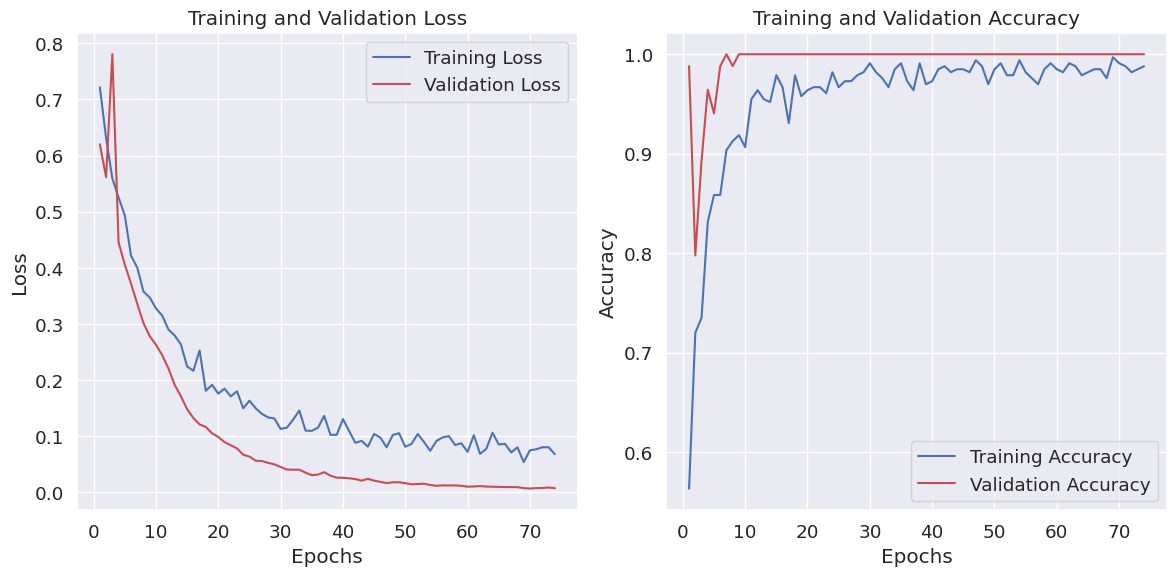

In [760]:
# Calculate class weights
y_vgg16= y_train
class_weights_vgg16 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_vgg16)

# Convert to dictionary
class_weight_dict_vgg16 = dict(enumerate(class_weights_vgg16))
#compile model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
vgg16_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_vgg16,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = vgg16_model.history.history['loss']
validation_loss = vgg16_model.history.history['val_loss']
training_accuracy = vgg16_model.history.history['accuracy']
validation_accuracy = vgg16_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [761]:
results_vgg16 = vgg16_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_vgg16[0])
print("Test Accuracy:", results_vgg16[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_vgg16 = vgg16_model.predict(x_test)

3/3 [==============================] - 0s 93ms/step - loss: 0.0061 - accuracy: 1.0000 - auc_188: 1.0000 - recall_188: 1.0000 - precision_188: 1.0000 - specificity_at_sensitivity_188: 1.0000 - sensitivity_at_specificity_188: 1.0000 - false_negatives_188: 0.0000e+00 - false_positives_188: 0.0000e+00 - true_negatives_188: 48.0000 - true_positives_188: 48.0000        
Test Loss: 0.006080950144678354
Test Accuracy: 1.0
3/3 [==============================] - 0s 80ms/step


3/3 [==============================] - 0s 78ms/step


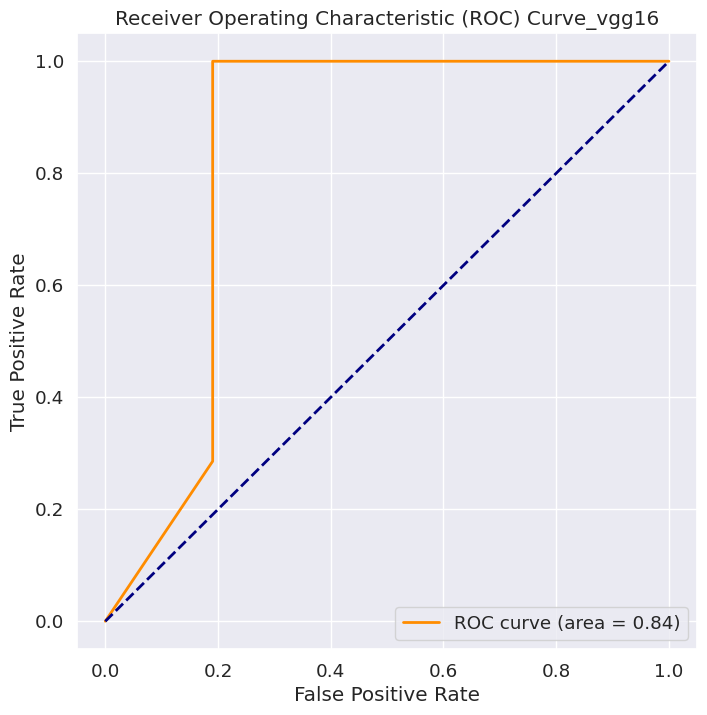

In [762]:
y_pred_vgg16 = vgg16_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_vgg16)

# Calculate the area under the curve (AUC)
roc_auc_vgg16 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_vgg16))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_vgg16')
plt.legend(loc='lower right')
plt.show()

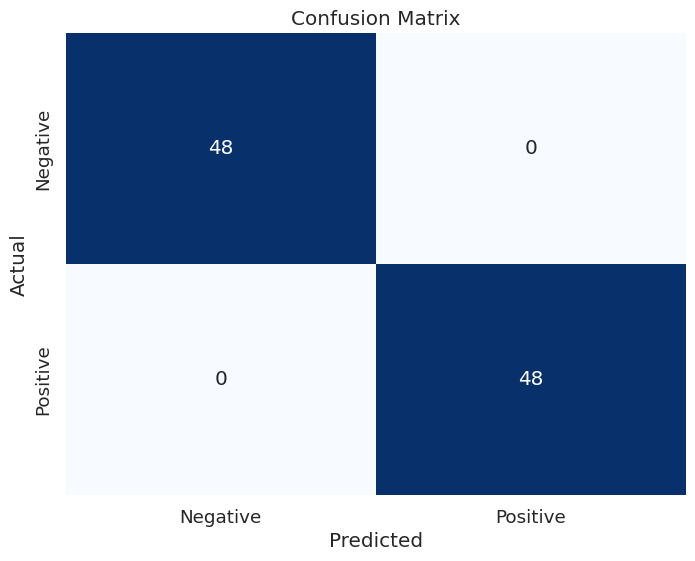

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [763]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_vgg16 = (predictions_vgg16 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_vgg16)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_vgg16 = f1_score(y_test, binary_predictions_vgg16)

# Print F1 score
print("F1 Score:", f1_vgg16)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_vgg16))

In [778]:
# Create a resnet50 model with pre-trained weights on ImageNet
pretrained_model_resnet50 = ResNet50(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

# Create a Sequential model
resnet50_model = Sequential()

# Add the resnet50 pre-trained model to your Sequential model
resnet50_model.add(pretrained_model_resnet50)

# Flatten layer
resnet50_model.add(Flatten())

# Dense layers
resnet50_model.add(Dense(16, activation='relu'))
resnet50_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("resnet50 Model Summary:")
resnet50_model.summary()

resnet50 Model Summary:
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_96 (Flatten)        (None, 2048)              0         
                                                                 
 dense_217 (Dense)           (None, 16)                32784     
                                                                 
 dense_218 (Dense)           (None, 1)                 17        
                                                                 
Total params: 23620513 (90.11 MB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/100
21/21 [==============================] - 7s 140ms/step - loss: 0.7600 - accuracy: 0.4608 - auc_192: 0.4962 - recall_192: 0.4398 - precision_192: 0.4591 - specificity_at_sensitivity_192: 0.4458 - sensitivity_at_specificity_192: 0.4398 - false_negatives_192: 93.0000 - false_positives_192: 86.0000 - true_negatives_192: 80.0000 - true_positives_192: 73.0000 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_auc_192: 0.7755 - val_recall_192: 0.0000e+00 - val_precision_192: 0.0000e+00 - val_specificity_at_sensitivity_192: 0.7143 - val_sensitivity_at_specificity_192: 0.8095 - val_false_negatives_192: 42.0000 - val_false_positives_192: 0.0000e+00 - val_true_negatives_192: 42.0000 - val_true_positives_192: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 1s 56ms/step - loss: 0.6871 - accuracy: 0.5633 - auc_192: 0.5869 - recall_192: 0.5783 - precision_192: 0.5614 - specificity_at_sensitivity_192: 0.6145 - sensitivity_at_specificity_192: 0.5964 - false_negatives_192: 70.00

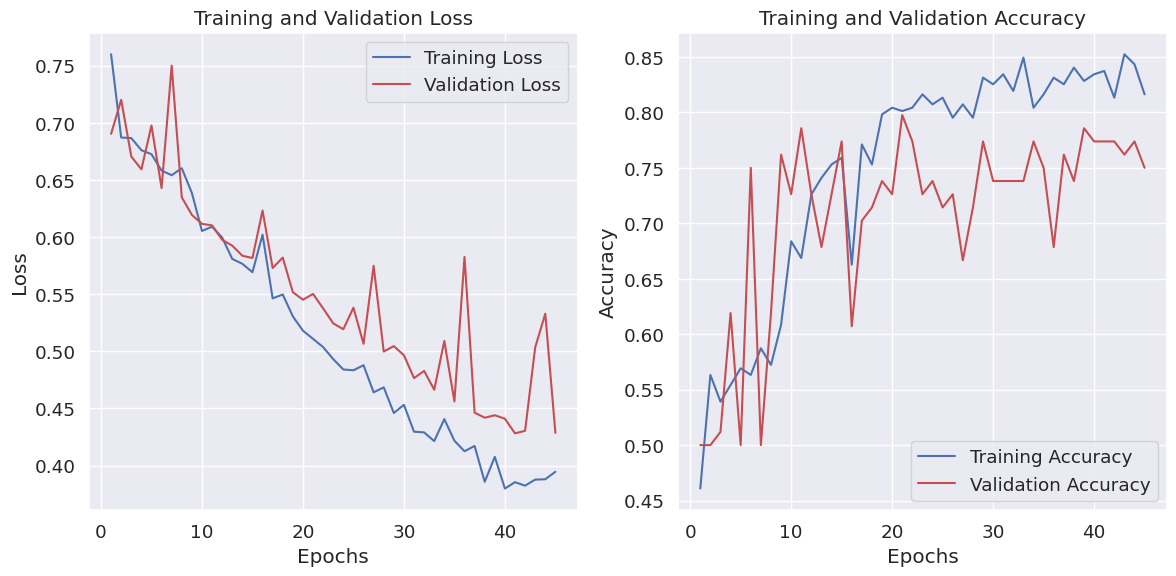

In [779]:
# Calculate class weights
y_resnet50= y_train
class_weights_resnet50 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_resnet50)

# Convert to dictionary
class_weight_dict_resnet50 = dict(enumerate(class_weights_resnet50))
#compile model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
resnet50_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_resnet50,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = resnet50_model.history.history['loss']
validation_loss = resnet50_model.history.history['val_loss']
training_accuracy = resnet50_model.history.history['accuracy']
validation_accuracy = resnet50_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [780]:
results_resnet50 = resnet50_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_resnet50[0])
print("Test Accuracy:", results_resnet50[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_resnet50 = resnet50_model.predict(x_test)

3/3 [==============================] - 0s 81ms/step - loss: 0.3557 - accuracy: 0.8854 - auc_192: 0.9759 - recall_192: 0.7708 - precision_192: 1.0000 - specificity_at_sensitivity_192: 1.0000 - sensitivity_at_specificity_192: 1.0000 - false_negatives_192: 11.0000 - false_positives_192: 0.0000e+00 - true_negatives_192: 48.0000 - true_positives_192: 37.0000     
Test Loss: 0.355663537979126
Test Accuracy: 0.8854166865348816
3/3 [==============================] - 1s 68ms/step


In [ ]:
y_pred_resnet50 = resnet50_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_resnet50)

# Calculate the area under the curve (AUC)
roc_auc_resnet50 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_resnet50))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_resnet50')
plt.legend(loc='lower right')
plt.show()

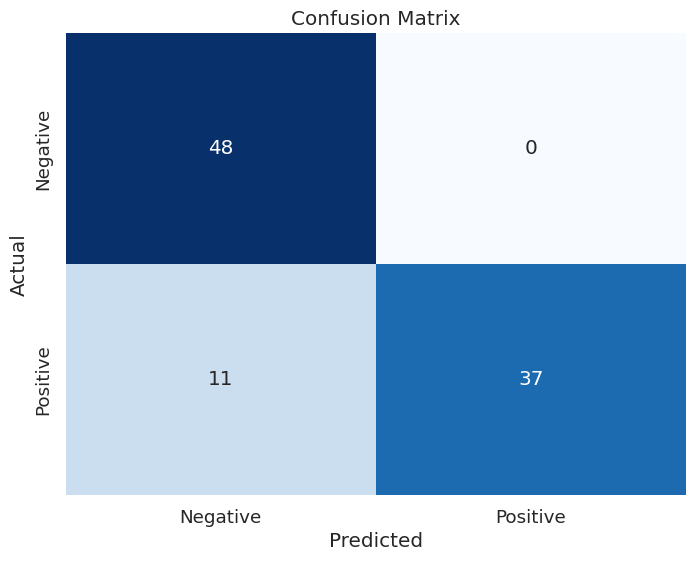

F1 Score: 0.8705882352941177
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        48
           1       1.00      0.77      0.87        48

    accuracy                           0.89        96
   macro avg       0.91      0.89      0.88        96
weighted avg       0.91      0.89      0.88        96



In [782]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_resnet50 = (predictions_resnet50 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_resnet50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_resnet50 = f1_score(y_test, binary_predictions_resnet50)

# Print F1 score
print("F1 Score:", f1_resnet50)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_resnet50))

In [769]:
# Create a DenseNet121 model with pre-trained weights on ImageNet
pretrained_model_DenseNet121 = DenseNet121(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_DenseNet121.layers:
    layer.trainable = False

# Create a Sequential model
DenseNet121_model = Sequential()

# Add the DenseNet121 pre-trained model to your Sequential model
DenseNet121_model.add(pretrained_model_DenseNet121)

# Flatten layer
DenseNet121_model.add(Flatten())

# Dense layers
DenseNet121_model.add(Dense(8, activation='relu'))
DenseNet121_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("DenseNet121 Model Summary:")
DenseNet121_model.summary()

DenseNet121 Model Summary:
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_94 (Flatten)        (None, 1024)              0         
                                                                 
 dense_213 (Dense)           (None, 8)                 8200      
                                                                 
 dense_214 (Dense)           (None, 1)                 9         
                                                                 
Total params: 7045713 (26.88 MB)
Trainable params: 8209 (32.07 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


Epoch 1/100
21/21 [==============================] - 11s 195ms/step - loss: 0.6267 - accuracy: 0.6717 - auc_190: 0.6890 - recall_190: 0.8434 - precision_190: 0.6278 - specificity_at_sensitivity_190: 0.6988 - sensitivity_at_specificity_190: 0.8434 - false_negatives_190: 26.0000 - false_positives_190: 83.0000 - true_negatives_190: 83.0000 - true_positives_190: 140.0000 - val_loss: 0.3104 - val_accuracy: 1.0000 - val_auc_190: 1.0000 - val_recall_190: 1.0000 - val_precision_190: 1.0000 - val_specificity_at_sensitivity_190: 1.0000 - val_sensitivity_at_specificity_190: 1.0000 - val_false_negatives_190: 0.0000e+00 - val_false_positives_190: 0.0000e+00 - val_true_negatives_190: 42.0000 - val_true_positives_190: 42.0000
Epoch 2/100
21/21 [==============================] - 1s 58ms/step - loss: 0.1840 - accuracy: 1.0000 - auc_190: 1.0000 - recall_190: 1.0000 - precision_190: 1.0000 - specificity_at_sensitivity_190: 1.0000 - sensitivity_at_specificity_190: 1.0000 - false_negatives_190: 0.0000e+00 

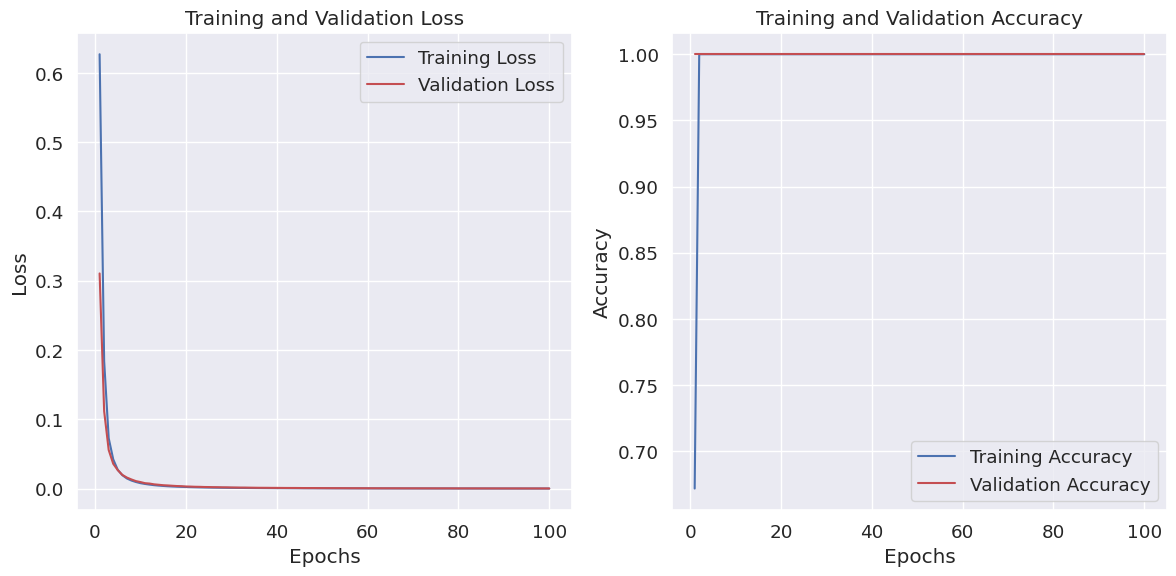

In [770]:
# Calculate class weights
y_DenseNet121= y_train
class_weights_DenseNet121 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_DenseNet121)

# Convert to dictionary
class_weight_dict_DenseNet121 = dict(enumerate(class_weights_DenseNet121))
#compile model
DenseNet121_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
DenseNet121_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_DenseNet121,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = DenseNet121_model.history.history['loss']
validation_loss = DenseNet121_model.history.history['val_loss']
training_accuracy = DenseNet121_model.history.history['accuracy']
validation_accuracy = DenseNet121_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [771]:
results_DenseNet121 = DenseNet121_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_DenseNet121[0])
print("Test Accuracy:", results_DenseNet121[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_DenseNet121 = DenseNet121_model.predict(x_test)

3/3 [==============================] - 0s 80ms/step - loss: 3.5211e-04 - accuracy: 1.0000 - auc_190: 1.0000 - recall_190: 1.0000 - precision_190: 1.0000 - specificity_at_sensitivity_190: 1.0000 - sensitivity_at_specificity_190: 1.0000 - false_negatives_190: 0.0000e+00 - false_positives_190: 0.0000e+00 - true_negatives_190: 48.0000 - true_positives_190: 48.0000        
Test Loss: 0.0003521079197525978
Test Accuracy: 1.0
3/3 [==============================] - 2s 67ms/step


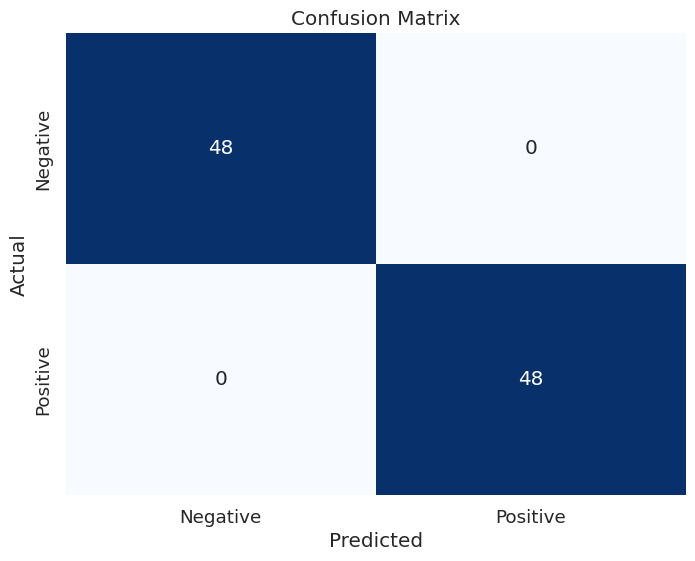

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [772]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_DenseNet121 = (predictions_DenseNet121 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_DenseNet121)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_DenseNet121 = f1_score(y_test, binary_predictions_DenseNet121)

# Print F1 score
print("F1 Score:", f1_DenseNet121)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_DenseNet121))

In [773]:
# Create a inceptionv3 model with pre-trained weights on ImageNet
pretrained_model_inceptionv3 = InceptionV3(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

# Create a Sequential model
inceptionv3_model = Sequential()

# Add the inceptionv3 pre-trained model to your Sequential model
inceptionv3_model.add(pretrained_model_inceptionv3)

# Flatten layer
inceptionv3_model.add(Flatten())

# Dense layers
inceptionv3_model.add(Dense(16, activation='relu'))
inceptionv3_model.add(Dropout(0.5))
inceptionv3_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("inceptionv3 Model Summary:")
inceptionv3_model.summary()

inceptionv3 Model Summary:
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_95 (Flatten)        (None, 2048)              0         
                                                                 
 dense_215 (Dense)           (None, 16)                32784     
                                                                 
 dropout_87 (Dropout)        (None, 16)                0         
                                                                 
 dense_216 (Dense)           (None, 1)                 17        
                                                                 
Total params: 21835585 (83.30 MB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 21802784 (83.17 MB)
______________________________________________

Epoch 1/100
21/21 [==============================] - 9s 152ms/step - loss: 0.4383 - accuracy: 0.7801 - auc_191: 0.8736 - recall_191: 0.7711 - precision_191: 0.7853 - specificity_at_sensitivity_191: 0.9398 - sensitivity_at_specificity_191: 0.9699 - false_negatives_191: 38.0000 - false_positives_191: 35.0000 - true_negatives_191: 131.0000 - true_positives_191: 128.0000 - val_loss: 0.1468 - val_accuracy: 0.9405 - val_auc_191: 0.9977 - val_recall_191: 0.9762 - val_precision_191: 0.9111 - val_specificity_at_sensitivity_191: 1.0000 - val_sensitivity_at_specificity_191: 1.0000 - val_false_negatives_191: 1.0000 - val_false_positives_191: 4.0000 - val_true_negatives_191: 38.0000 - val_true_positives_191: 41.0000
Epoch 2/100
21/21 [==============================] - 1s 50ms/step - loss: 0.1433 - accuracy: 0.9518 - auc_191: 0.9917 - recall_191: 0.9458 - precision_191: 0.9573 - specificity_at_sensitivity_191: 1.0000 - sensitivity_at_specificity_191: 1.0000 - false_negatives_191: 9.0000 - false_posi

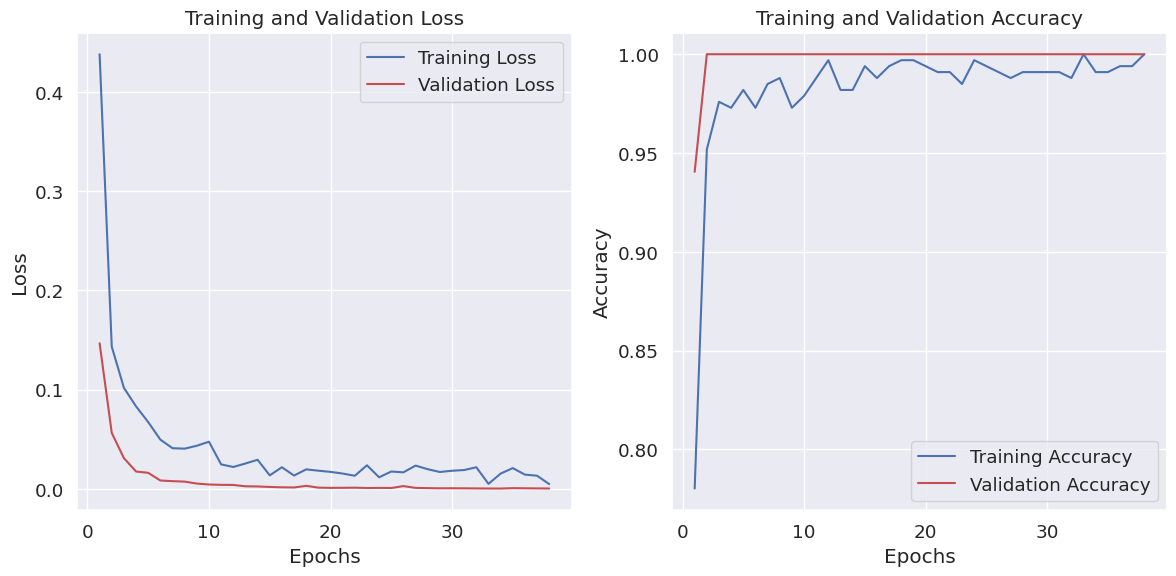

In [774]:
# Calculate class weights
y_inceptionv3= y_train
class_weights_inceptionv3 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_inceptionv3)

# Convert to dictionary
class_weight_dict_inceptionv3 = dict(enumerate(class_weights_inceptionv3))
#compile model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
inceptionv3_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_inceptionv3,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = inceptionv3_model.history.history['loss']
validation_loss = inceptionv3_model.history.history['val_loss']
training_accuracy = inceptionv3_model.history.history['accuracy']
validation_accuracy = inceptionv3_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [775]:
results_inceptionv3 = inceptionv3_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_inceptionv3[0])
print("Test Accuracy:", results_inceptionv3[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_inceptionv3 = inceptionv3_model.predict(x_test)

3/3 [==============================] - 0s 67ms/step - loss: 1.5376e-04 - accuracy: 1.0000 - auc_191: 1.0000 - recall_191: 1.0000 - precision_191: 1.0000 - specificity_at_sensitivity_191: 1.0000 - sensitivity_at_specificity_191: 1.0000 - false_negatives_191: 0.0000e+00 - false_positives_191: 0.0000e+00 - true_negatives_191: 48.0000 - true_positives_191: 48.0000        
Test Loss: 0.00015375511429738253
Test Accuracy: 1.0
3/3 [==============================] - 1s 53ms/step


In [ ]:
y_pred_inceptionv3 = inceptionv3_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_inceptionv3)

# Calculate the area under the curve (AUC)
roc_auc_inceptionv3 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_inceptionv3))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_inceptionv3')
plt.legend(loc='lower right')
plt.show()

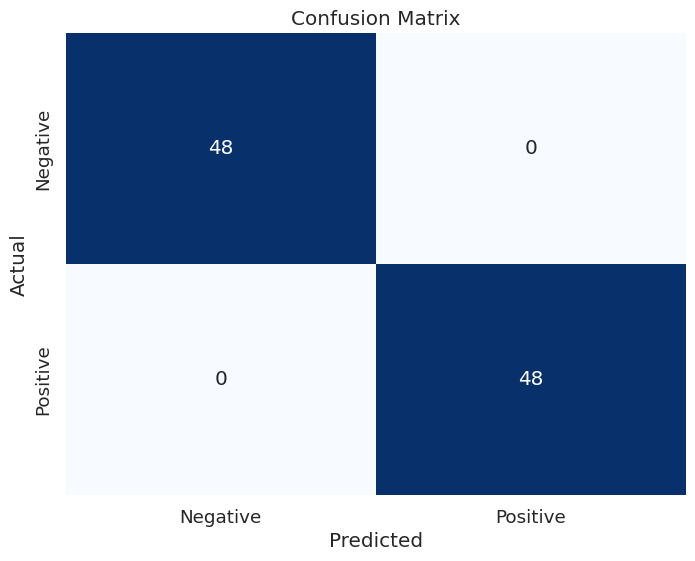

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [777]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_inceptionv3 = (predictions_inceptionv3 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_inceptionv3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_inceptionv3 = f1_score(y_test, binary_predictions_inceptionv3)

# Print F1 score
print("F1 Score:", f1_inceptionv3)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_inceptionv3))